In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.listdir("/content/drive/My Drive/deeprock")

['training_sets.zip']


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [ ]:
!unzip "/content/drive/My Drive/deeprock/training_sets.zip" -d "training_sets"

Streaming output truncated to the last 5000 lines.
  inflating: training_sets/training_sets/train/sandstone/0614.png  
  inflating: training_sets/training_sets/train/sandstone/0615.png  
  inflating: training_sets/training_sets/train/sandstone/0616.png  
  inflating: training_sets/training_sets/train/sandstone/0617.png  
  inflating: training_sets/training_sets/train/sandstone/0618.png  
  inflating: training_sets/training_sets/train/sandstone/0619.png  
  inflating: training_sets/training_sets/train/sandstone/0620.png  
  inflating: training_sets/training_sets/train/sandstone/0621.png  
  inflating: training_sets/training_sets/train/sandstone/0622.png  
  inflating: training_sets/training_sets/train/sandstone/0623.png  
  inflating: training_sets/training_sets/train/sandstone/0624.png  
  inflating: training_sets/training_sets/train/sandstone/0625.png  
  inflating: training_sets/training_sets/train/sandstone/0626.png  
  inflating: training_sets/training_sets/train/sandstone/0627.png

In [ ]:
import imageio
import torch
from PIL import Image
from matplotlib import cm

def loader(path):
  img = Image.fromarray(imageio.imread(path))
  return img

In [ ]:
root_train = "training_sets/training_sets/train"
root_val = "training_sets/training_sets/val"
root_test = "training_sets/training_sets/test"



In [ ]:
print(train_dataset[0][0].size(), train_dataset[0][1])
plt.imshow(train_dataset[0][0][2])

NameError: ignored

In [ ]:
import os
print(os.getcwd())
print(os.listdir(os.getcwd()))
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = torchvision.datasets.DatasetFolder(root_train, loader, extensions=".png", transform=data_transforms['train'], target_transform=None)
val_dataset = torchvision.datasets.DatasetFolder(root_val, loader, extensions=".png", transform=data_transforms['val'], target_transform=None)
#test_dataset = torchvision.datasets.DatasetFolder(root_test, loader, extensions=".png", transform=None, target_transform=None)

image_datasets = {'train': train_dataset, 'val': val_dataset}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/content
['.config', 'training_sets', 'drive', 'sample_data']


In [ ]:
train_dataset.classes

['carbonate', 'coal', 'sandstone']

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



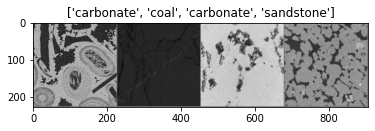

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device).float()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.alexnet(pretrained=True)

model_ft.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 3),
        )

#num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

for X, y in dataloaders['train']:
  print(X.size())
  print(y.size())
  break

#model(dataloaders['train'][0])

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



torch.Size([4, 3, 224, 224])
torch.Size([4])


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.0471 Acc: 0.9814
val Loss: 0.0463 Acc: 0.9908

Training complete in 1m 42s
Best val Acc: 0.990833


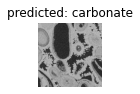

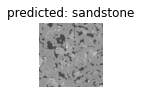

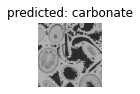

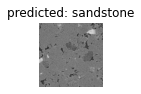

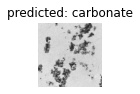

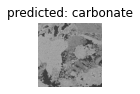

In [ ]:
visualize_model(model_ft)

In [ ]:
torch.save( model_ft.state_dict(), "alexnet_deeprock.pth")

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.alexnet(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 3),
        )

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0607 Acc: 0.9775
val Loss: 0.0010 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.0184 Acc: 0.9936
val Loss: 0.0048 Acc: 0.9983

Epoch 2/24
----------
train Loss: 0.0122 Acc: 0.9959
val Loss: 0.0001 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.0070 Acc: 0.9978
val Loss: 0.0039 Acc: 0.9983

Epoch 4/24
----------
train Loss: 0.0112 Acc: 0.9958
val Loss: 0.0021 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.0090 Acc: 0.9969
val Loss: 0.0011 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.0059 Acc: 0.9975
val Loss: 0.0000 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0041 Acc: 0.9989
val Loss: 0.0000 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0030 Acc: 0.9986
val Loss: 0.0000 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0033 Acc: 0.9989
val Loss: 0.0000 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0041 Acc: 0.9989
val Loss: 0.0000 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0027 Acc: 0.9990
val Loss: 0.0000 Acc: 1.0000

Ep

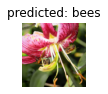

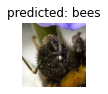

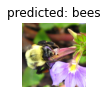

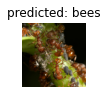

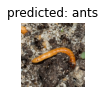

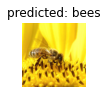

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.



